# Applied ML Assignment 1

Training Model

Name- Soham Sengupta                      
                   Roll No.- MDS202241

In [63]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import xgboost as xgb
from tqdm.auto import tqdm
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

Functions to fit model

In [4]:
def log_reg(train_data, y_train):
    
    model = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english')),
        ('clf', LogisticRegression(class_weight='balanced',random_state=41))
    ])
    
    model.fit(train_data, y_train)
    return model

In [5]:
def lgbm_clas(train_data, y_train):
    
    model = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english')),
        ('clf', lgb.LGBMClassifier(class_weight='balanced',random_state=41,force_row_wise=True))
    ])
    
    model.fit(train_data, y_train)
    return model

In [7]:
def xgbm_clas(train_data, y_train):
    
    model = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english')),
        ('clf', xgb.XGBClassifier(class_weight='balanced',random_state=41))
    ])
    
    model.fit(train_data, y_train)
    return model

In [8]:
def score_model(model, data, y_true):
    y_pred = model.predict(data)
    return accuracy_score(y_true, y_pred)

In [9]:
def evaluate_model(y_true, y_pred):
    print(classification_report(y_true, y_pred))

In [10]:
def validate_model(model, train_data, y_train, validation_data, y_val):
    print("Train score:", score_model(model, train_data, y_train))
    print("Validation score:", score_model(model, validation_data, y_val))

In [11]:
train_data = pd.read_csv('train.csv')
validation_data = pd.read_csv('validation.csv')
test_data = pd.read_csv('test.csv')

In [12]:
train_data

,text,spam
0,subject avfs romanian software production expo...,1
1,subject arthur andersen model validation reque...,0
2,subject vacation shirley problem please coordi...,0
3,subject mortgage even worst credit zwzm detail...,1
4,subject 4 00 pm budget meeting dave continue f...,0
...,...,...
4863,subject accounting adjustment kim fyi checked ...,0
4864,subject pleased get note wish could help respe...,0
4865,subject mscf speaker series pierre philippe ti...,0
4866,subject sometimes always like idea chick horse...,1


In [13]:
X_train = train_data['text']
y_train = train_data['spam']
X_val = validation_data['text']
y_val = validation_data['spam']
X_test = test_data['text']
y_test = test_data['spam']

For logistic regression

In [14]:
log=log_reg(X_train, y_train)

In [16]:
validate_model(log, X_train, y_train, X_val, y_val)

Train score: 0.9942481511914544
Validation score: 0.9837209302325581


In [17]:
y_pred_val = log.predict(X_val)

In [18]:
evaluate_model(y_val, y_pred_val)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       330
           1       0.93      1.00      0.97       100

    accuracy                           0.98       430
   macro avg       0.97      0.99      0.98       430
weighted avg       0.98      0.98      0.98       430



We can see logistic regression using balanced class yields 98% accuracy

For Light Gradient Boosting Machine

In [19]:
lg=lgbm_clas(X_train, y_train)

[LightGBM] [Info] Number of positive: 1174, number of negative: 3694
[LightGBM] [Info] Total Bins 108354
[LightGBM] [Info] Number of data points in the train set: 4868, number of used features: 3236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


In [23]:
validate_model(lg, X_train, y_train, X_val, y_val)

Train score: 0.9997945768282662
Validation score: 0.9790697674418605


In [24]:
y_pred_val = lg.predict(X_val)
evaluate_model(y_val, y_pred_val)

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       330
           1       0.92      1.00      0.96       100

    accuracy                           0.98       430
   macro avg       0.96      0.99      0.97       430
weighted avg       0.98      0.98      0.98       430



Using Validation class, lgbm is also yielding 98% accuracy.

For Xg-boost

In [22]:
xg=xgbm_clas(X_train, y_train)

[16:32:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [25]:
validate_model(xg, X_train, y_train, X_val, y_val)

Train score: 0.9995891536565324
Validation score: 0.9813953488372092


In [26]:
y_pred_val = xg.predict(X_val)
evaluate_model(y_val, y_pred_val)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       330
           1       0.93      0.99      0.96       100

    accuracy                           0.98       430
   macro avg       0.97      0.98      0.97       430
weighted avg       0.98      0.98      0.98       430



Xg-boost also yielding 98% accuracy

Without fine tuning all models are neck to neck

Grid-search

In [27]:
# Combine the training and validation sets for final fine-tuning
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

In [29]:
# Define the base models
models_gcv = {
    'logistic_regression': Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english')),
        ('clf', LogisticRegression(random_state=41))
    ]),
    'lightgbm': Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english')),
        ('clf', lgb.LGBMClassifier(random_state=41, force_row_wise=True))
    ]),
    'xgbm': Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english')),
        ('clf', xgb.XGBClassifier(class_weight='balanced',random_state=41))
    ])
}

# Define the parameter grids for each model
param_grids = {
    'logistic_regression': {
        'tfidf__max_df': [0.5, 0.75],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf__C': [0.1, 1, 10]
    },
    'lightgbm': {
        'tfidf__max_df': [0.5, 0.75],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf__learning_rate': [0.01, 0.1, 0.5],
        'clf__num_leaves': [15,31,63],
        'clf__max_depth': [6, 8]
           
    },
    'xgbm': {
        'tfidf__max_df': [0.5, 0.75],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf__learning_rate': [0.01, 0.1, 0.5],
        'clf__num_leaves': [15,31,63],
        'clf__max_depth': [6, 8]
    }
}

In [30]:
model_name=[['logistic_regression', 'lightgbm','xgbm']]

Fine tuning..

In [33]:
best_models = {}
for model_name in tqdm(models_gcv.keys(), desc="Grid Searching Models"):
    print(f"Starting grid search for {model_name}...")
    grid_search = GridSearchCV(models_gcv[model_name], param_grids[model_name], cv=3, n_jobs=-1, verbose=1)
    grid_search.fit(X_train_val,y_train_val )
    
    print(f"Best parameters for {model_name}:")
    print(grid_search.best_params_)
    
    best_models[model_name] = grid_search.best_estimator_

Grid Searching Models:   0%|          | 0/3 [00:00<?, ?it/s]

Starting grid search for logistic_regression...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for logistic_regression:
{'clf__C': 10, 'tfidf__max_df': 0.5, 'tfidf__ngram_range': (1, 1)}
Starting grid search for lightgbm...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1274, number of negative: 4024
[LightGBM] [Info] Total Bins 116707
[LightGBM] [Info] Number of data points in the train set: 5298, number of used features: 3376
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240468 -> initscore=-1.150115
[LightGBM] [Info] Start training from score -1.150115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

In [34]:
best_models

{'logistic_regression': Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.5, stop_words='english')),
                 ('clf', LogisticRegression(C=10, random_state=41))]),
 'lightgbm': Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.5, stop_words='english')),
                 ('clf',
                  LGBMClassifier(force_row_wise=True, learning_rate=0.5,
                                 max_depth=6, random_state=41))]),
 'xgbm': Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.5, stop_words='english')),
                 ('clf',
                  XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                                class_weight='balanced', colsample_bylevel=1,
                                colsample_bynode=1, colsample_bytree=1,
                                early_stopping_rounds=None,
                                enable_categorical=False, eval_metric=None,
                                gamma=0, gpu_id=-1, grow_policy='depthwise',
              

In [35]:
test_accuracies = {}

for model_name, model in tqdm(best_models.items()):
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    test_accuracies[model_name] = accuracy
    
    print(f"{model_name} Test Accuracy: {accuracy}")

  0%|          | 0/3 [00:00<?, ?it/s]

logistic_regression Test Accuracy: 0.9976744186046511
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
lightgbm Test Accuracy: 0.9953488372093023
xgbm Test Accuracy: 0.986046511627907


Hence on Test data we can see that logistic Regression slightly out performs the other two after grid search , though all giving accuracy very good, also before grid search it was good enough , so grid search and fine tuning is optional.

In [36]:
model= Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.5, stop_words='english')),
                 ('clf', LogisticRegression(C=10, random_state=41))])

In [39]:
model.fit(X_train_val, y_train_val)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.5, stop_words='english')),
                ('clf', LogisticRegression(C=10, random_state=41))])

In [40]:
y_pred = model.predict(X_test)

Text(113.9222222222222, 0.5, 'Actual label')

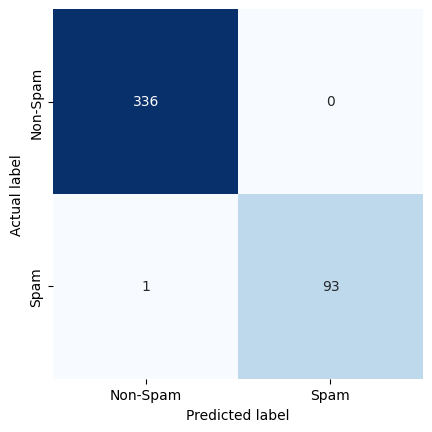

In [45]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
labels = ['Non-Spam', 'Spam']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

In [46]:
evaluate_model(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       336
           1       1.00      0.99      0.99        94

    accuracy                           1.00       430
   macro avg       1.00      0.99      1.00       430
weighted avg       1.00      1.00      1.00       430



As,we can see from the confusion matrix and report our model can almost estimate all mails in their classes in test set with almost full accuracy.

# ROC Curve

In [57]:
y_proba = model.predict_proba(X_test)[:, 1]

In [58]:
y_proba

array([6.36608877e-03, 8.77039117e-04, 9.96979269e-01, 5.03497132e-03,
       3.05965343e-02, 9.67019673e-01, 3.03877822e-03, 9.95914259e-01,
       1.13142994e-04, 9.60463722e-01, 3.01192291e-05, 5.17201578e-03,
       1.93137813e-03, 9.77915301e-01, 3.32200111e-02, 2.17460434e-04,
       2.21204750e-03, 2.65721143e-04, 1.99532145e-05, 9.04516825e-04,
       2.13748210e-03, 4.92604032e-04, 8.71726585e-01, 2.22217128e-02,
       9.94750042e-01, 6.97618241e-02, 2.81090326e-03, 5.76748846e-03,
       1.49827614e-01, 3.73735005e-02, 1.22296653e-01, 9.13703318e-01,
       9.96679265e-01, 5.14450082e-03, 9.96307710e-01, 3.54294177e-02,
       2.25992886e-03, 1.47276551e-02, 5.84311321e-03, 4.02712465e-03,
       4.96633734e-03, 9.92897964e-01, 1.39637055e-02, 9.52710899e-01,
       9.86655894e-01, 5.67583896e-02, 7.97323832e-04, 5.99913320e-06,
       3.25713759e-05, 9.08517614e-02, 3.63458259e-03, 9.85244032e-03,
       1.31173183e-03, 4.95292361e-04, 9.28760996e-01, 9.87843641e-01,
      

In [61]:
pred_prob = list((y_pred))

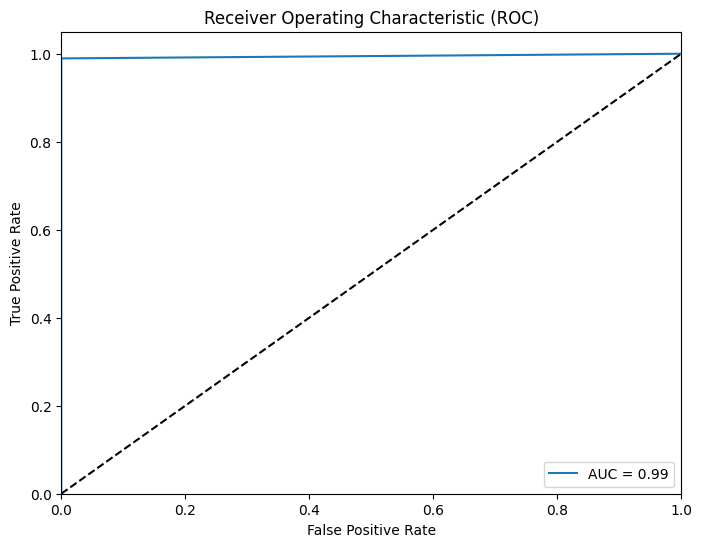

In [64]:
# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, pred_prob)
roc_auc = roc_auc_score(y_test, pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

From the graph we can see area under the curve is 99%. Hence our model works very well